In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

2024-08-10 22:28:56.268890: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 22:28:56.271844: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 22:28:56.310941: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 22:28:57.071007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.random.set_seed(123)
# Cargar el archivo depurado.csv
data = pd.read_csv('depurado.csv')

# Convertir la columna de fecha a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Ordenar los datos por fecha
data = data.sort_values('Fecha')
print ('\n Parsed Data:')
data.head()


 Parsed Data:


,Unnamed: 0,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
0,0,2001-01-01,0.0,27748.99,214581.84,0.0,0.0,0.0,0.0,194065.738095,...,0.0,0.0,0.0,0.0,0.0,566101.99,8402.0,0.0,715344.0,2.312639e+06
1,1,2001-02-01,0.0,7503.57,294609.00,0.0,0.0,0.0,0.0,170703.380952,...,0.0,0.0,0.0,0.0,0.0,489525.80,0.0,0.0,370166.0,1.769209e+06
2,2,2001-03-01,0.0,26304.32,315263.80,0.0,0.0,0.0,0.0,161837.371429,...,0.0,0.0,0.0,0.0,0.0,575559.68,0.0,0.0,360530.0,1.945770e+06
3,3,2001-04-01,0.0,7885.89,205653.00,0.0,0.0,0.0,0.0,163048.642857,...,0.0,0.0,0.0,0.0,0.0,437745.42,8184.0,0.0,359527.0,1.623638e+06
4,4,2001-05-01,0.0,8443.16,278371.30,0.0,0.0,0.0,0.0,171518.861905,...,0.0,0.0,0.0,0.0,0.0,552609.13,12680.0,0.0,723346.0,2.262727e+06


In [3]:
data.columns

Index(['Unnamed: 0', 'Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker',
       'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido',
       'Total importación'],
      dtype='object')

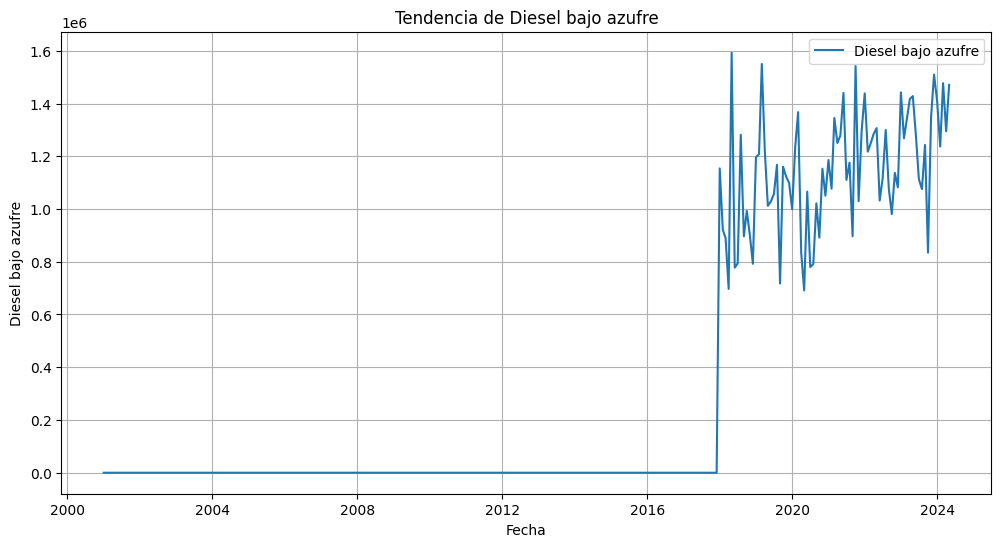

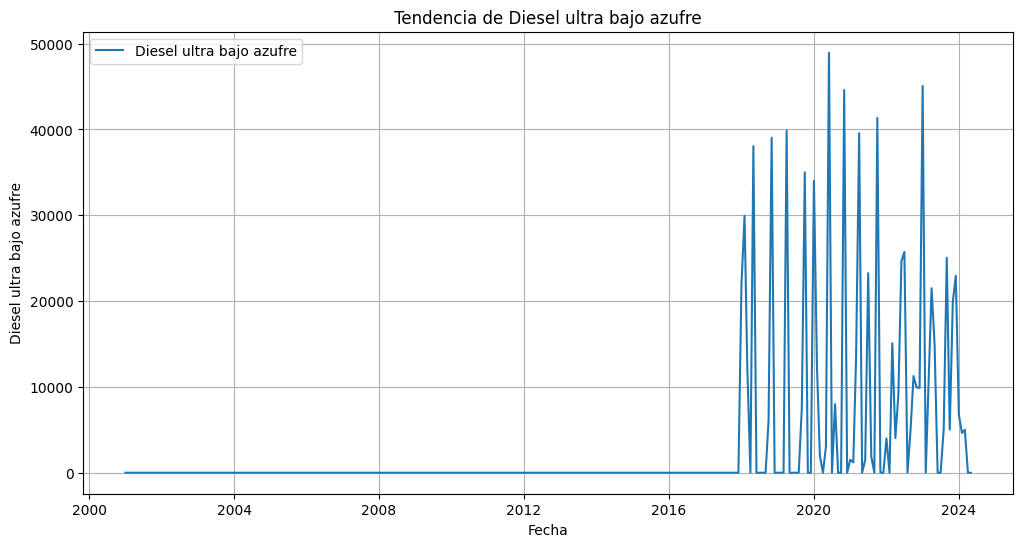

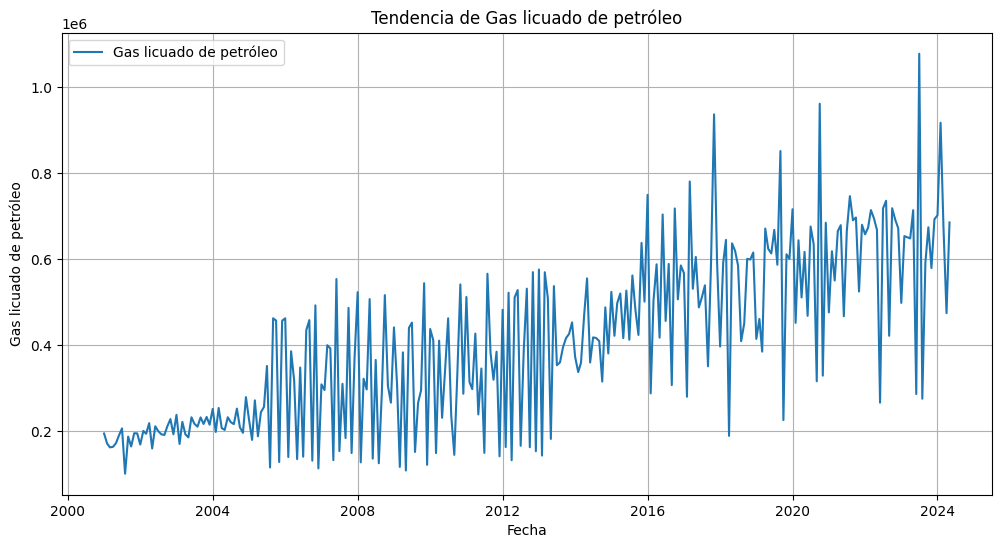

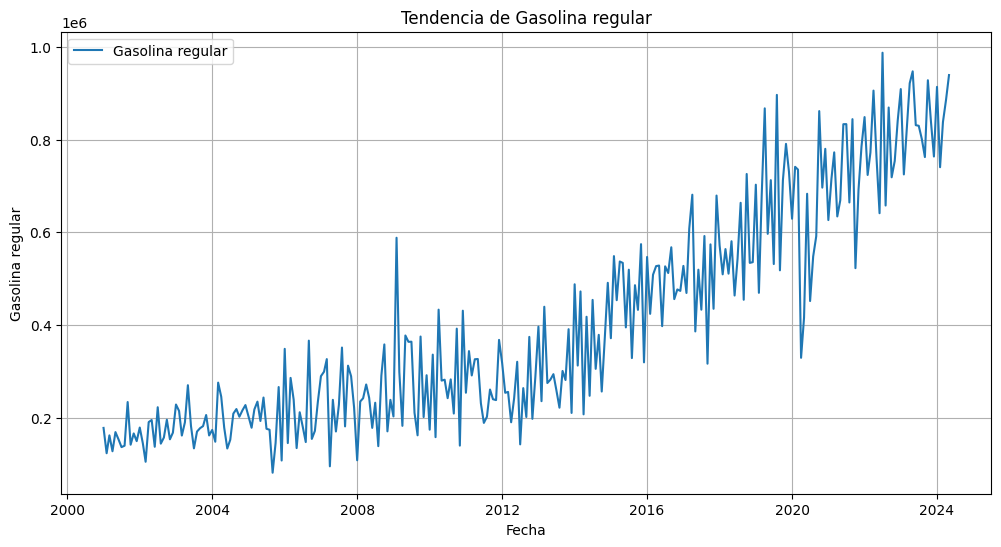

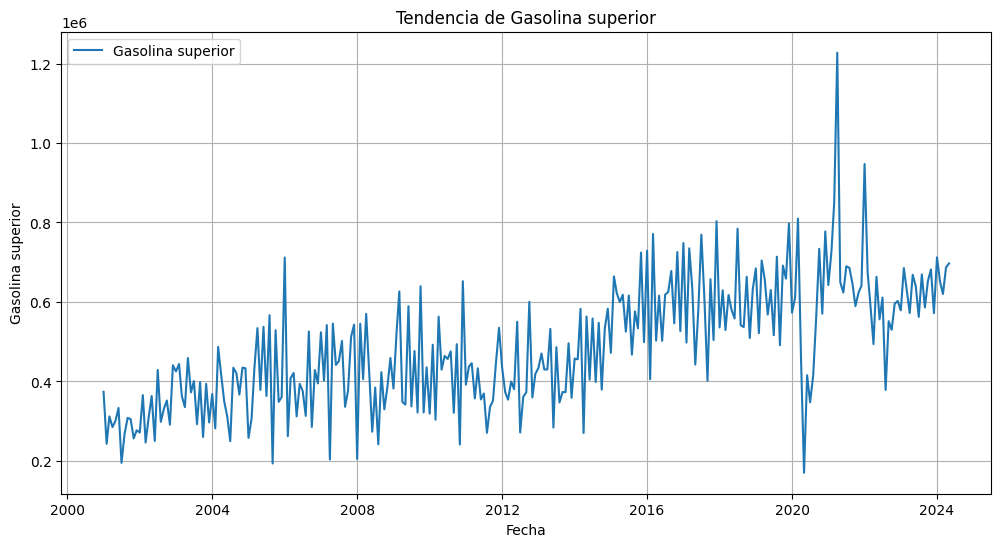

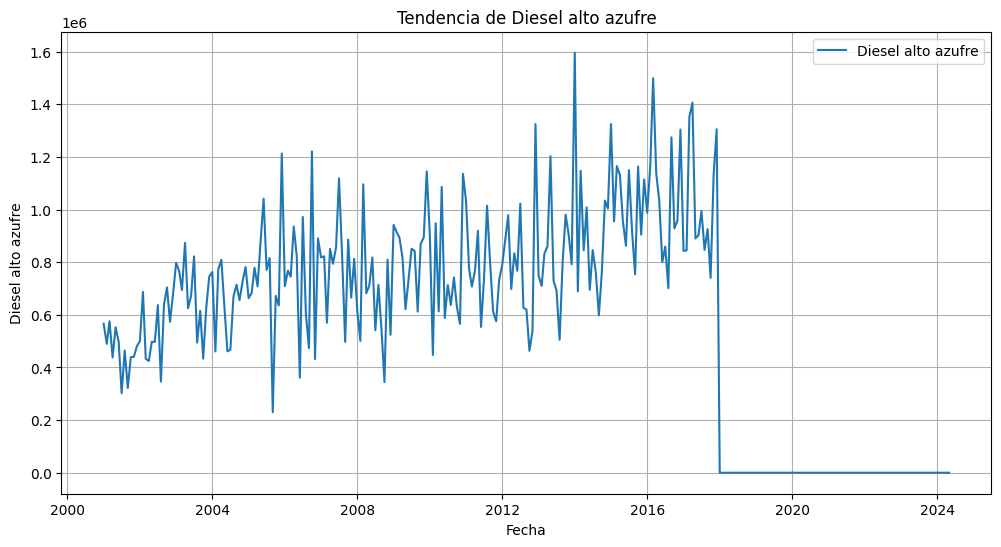

In [4]:
# Establecer la columna de fecha como índice
data.set_index('Fecha', inplace=True)
# Lista de columnas de interés
columns_interes = [
    'Diesel bajo azufre',
    'Diesel ultra bajo azufre',
    'Gas licuado de petróleo',
    'Gasolina regular',
    'Gasolina superior',
    'Diesel alto azufre'
]

# Graficar cada columna de interés
for column in columns_interes:
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[column], label=column)
    plt.title(f'Tendencia de {column}')
    plt.xlabel('Fecha')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()


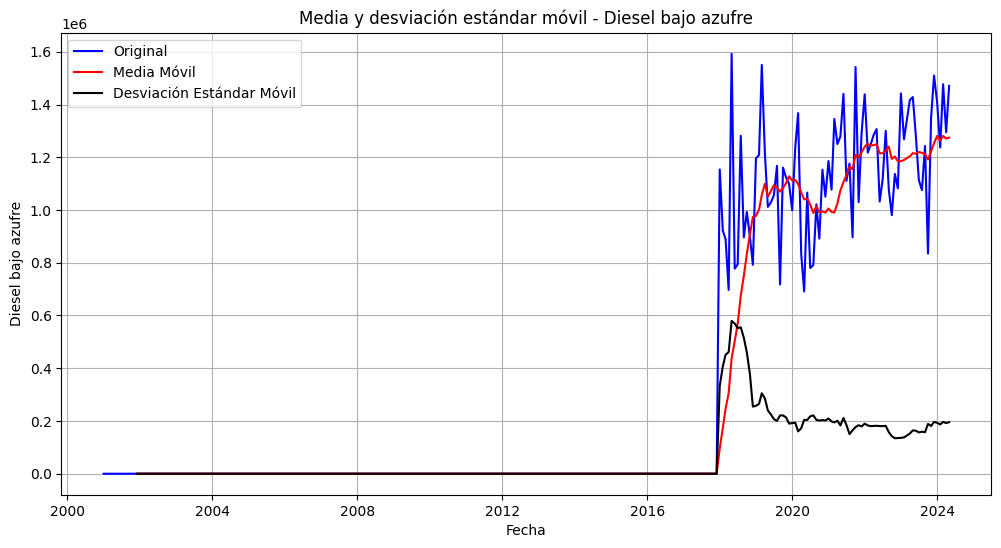

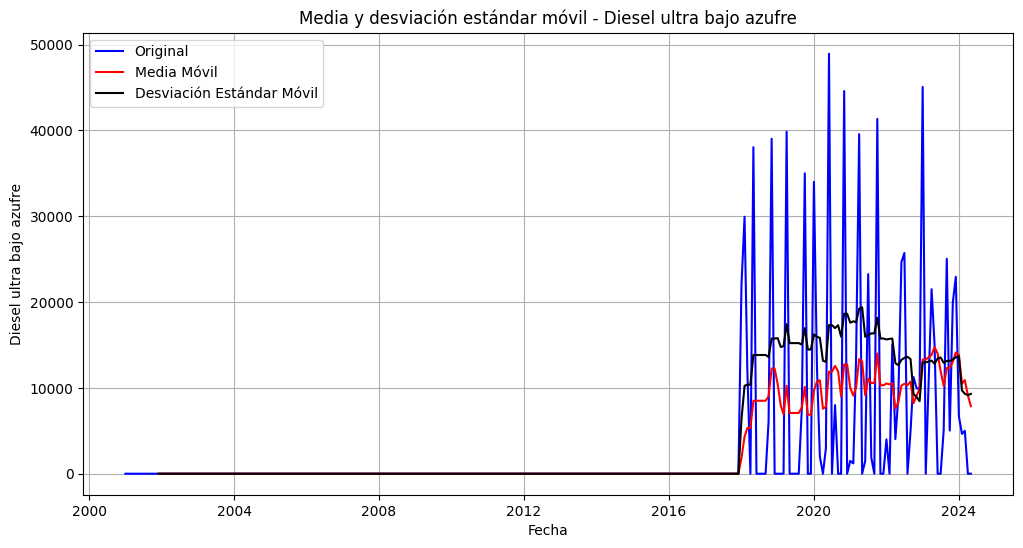

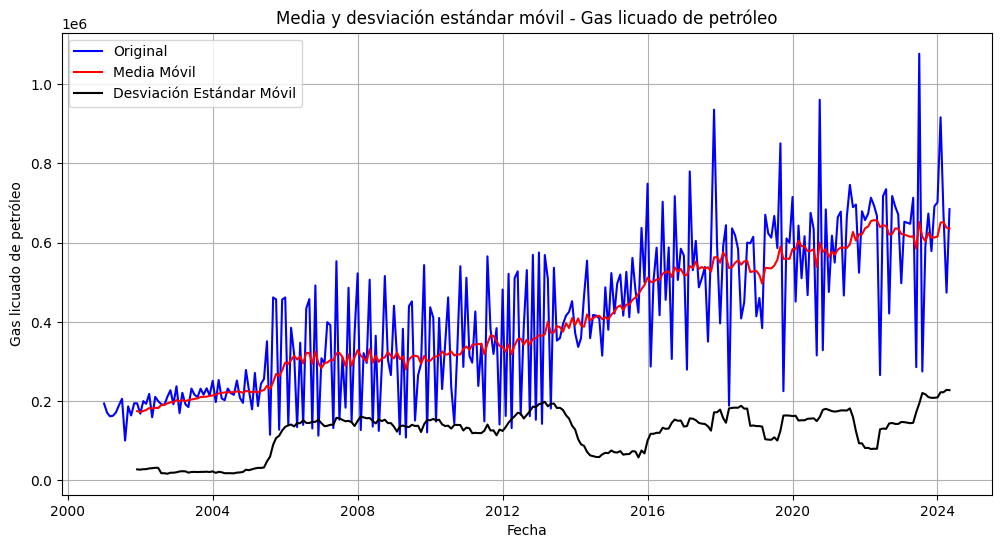

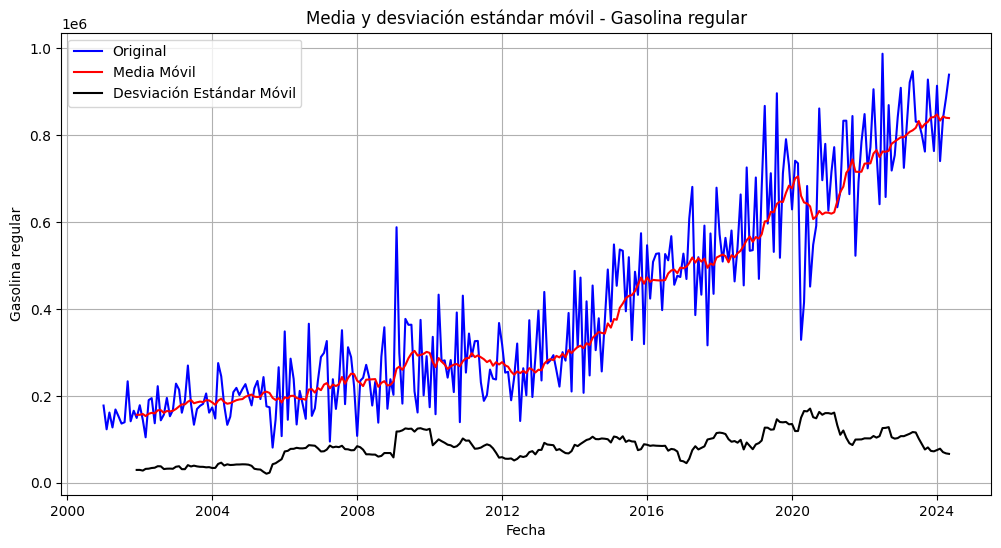

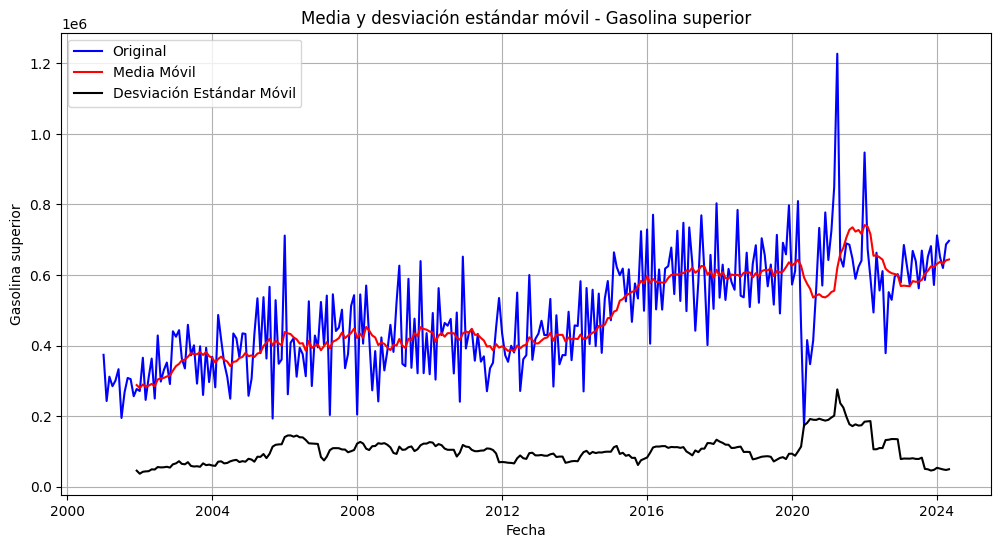

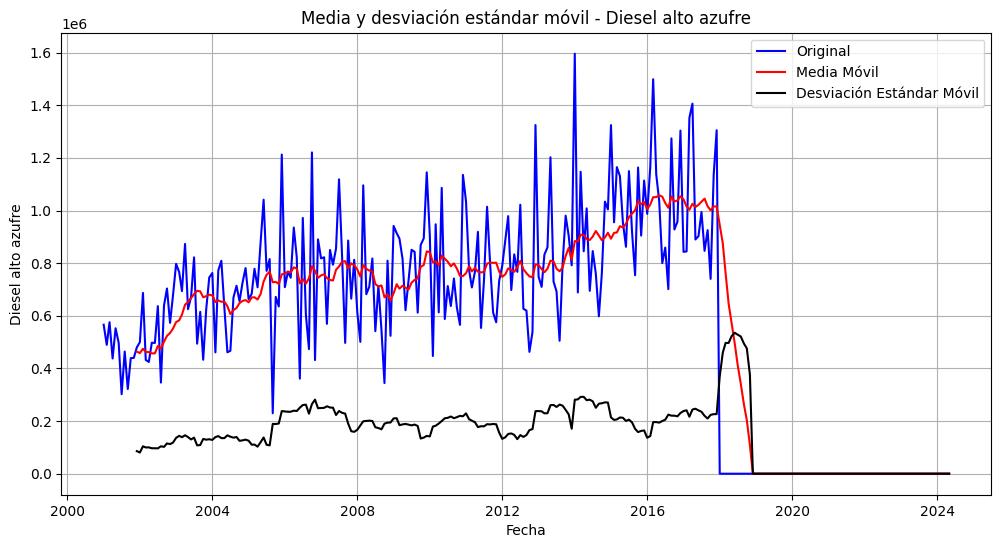

In [5]:
# Calcular y graficar la media móvil y la desviación estándar móvil para cada columna
for column in columns_interes:
    plt.figure(figsize=(12, 6))
    
    # Calcular la media móvil y la desviación estándar móvil
    mediaMovil = data[column].rolling(window=12).mean()
    deMovil = data[column].rolling(window=12).std()
    
    # Graficar los resultados
    plt.plot(data[column], color="blue", label="Original")
    plt.plot(mediaMovil, color='red', label='Media Móvil')
    plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
    
    # Configurar el gráfico
    plt.legend(loc='best')
    plt.title(f'Media y desviación estándar móvil - {column}')
    plt.xlabel('Fecha')
    plt.ylabel(column)
    plt.grid(True)
    
    # Mostrar el gráfico
    plt.show()

<Figure size 1200x800 with 0 Axes>

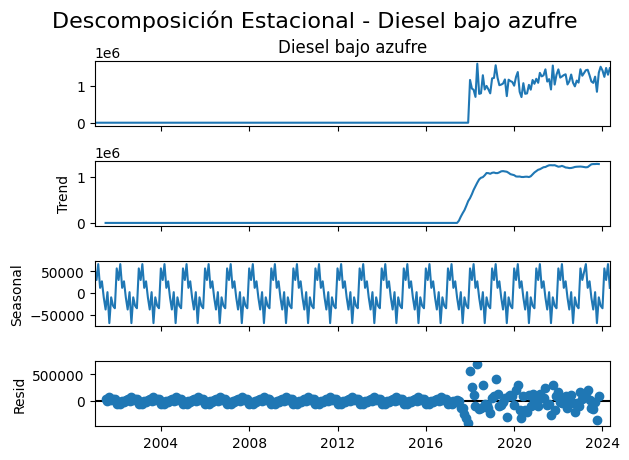

<Figure size 1200x800 with 0 Axes>

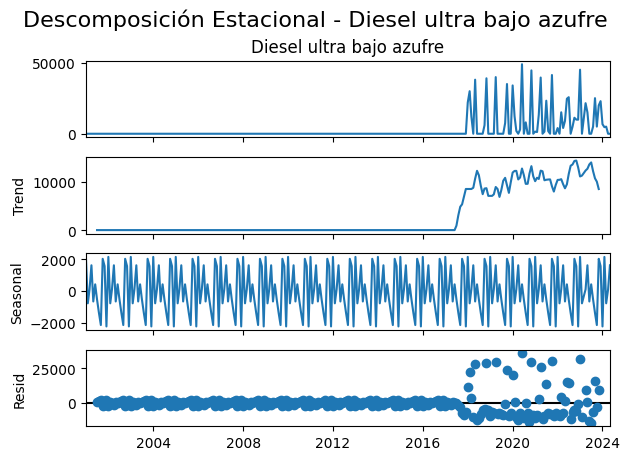

<Figure size 1200x800 with 0 Axes>

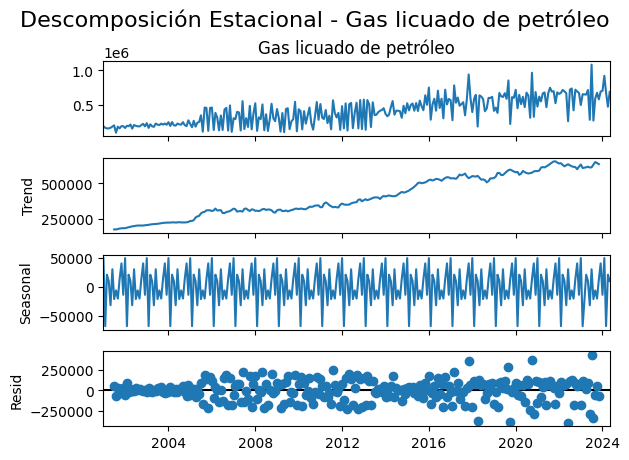

<Figure size 1200x800 with 0 Axes>

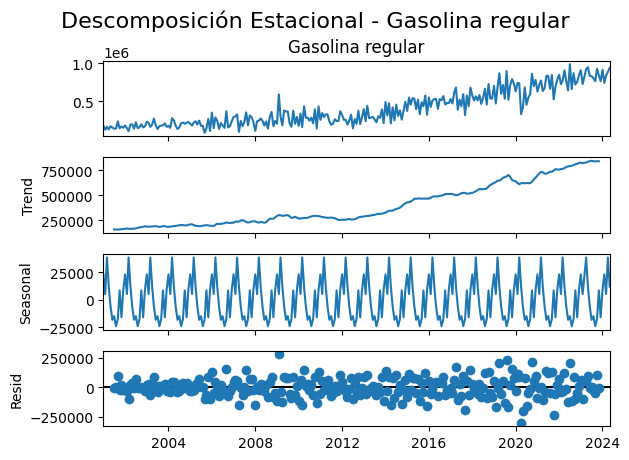

<Figure size 1200x800 with 0 Axes>

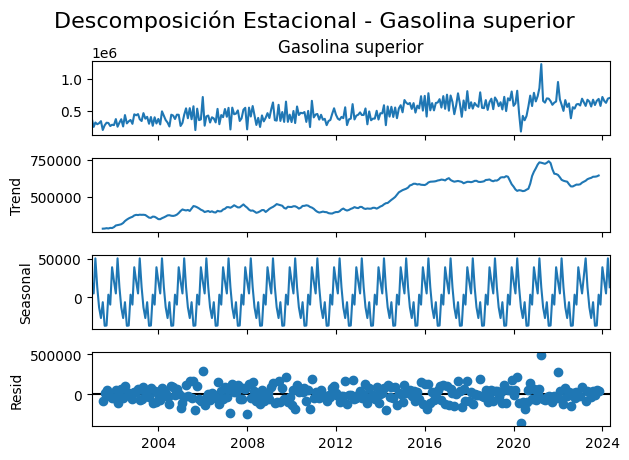

<Figure size 1200x800 with 0 Axes>

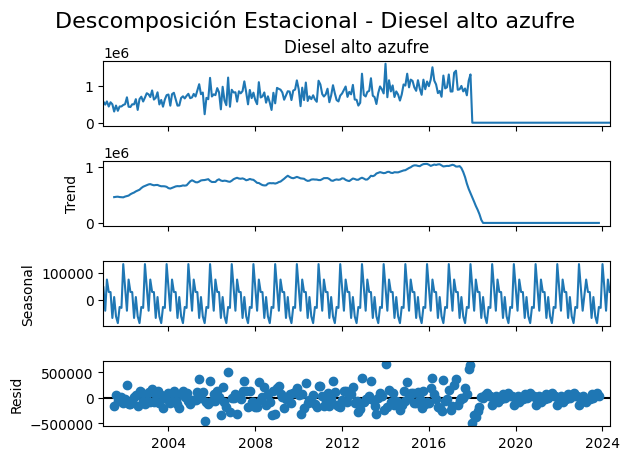

In [6]:
for column in columns_interes:
    plt.figure(figsize=(12, 8))
    
    # Realizar la descomposición estacional con el modelo aditivo
    descomposicion = seasonal_decompose(data[column], model='additive', period=12)
    
    # Graficar la descomposición
    descomposicion.plot()
    
    # Ajustar el espaciado
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Agregar el título general
    plt.suptitle(f'Descomposición Estacional - {column}', fontsize=16)
    
    # Mostrar el gráfico
    plt.show()


<Figure size 1200x800 with 0 Axes>

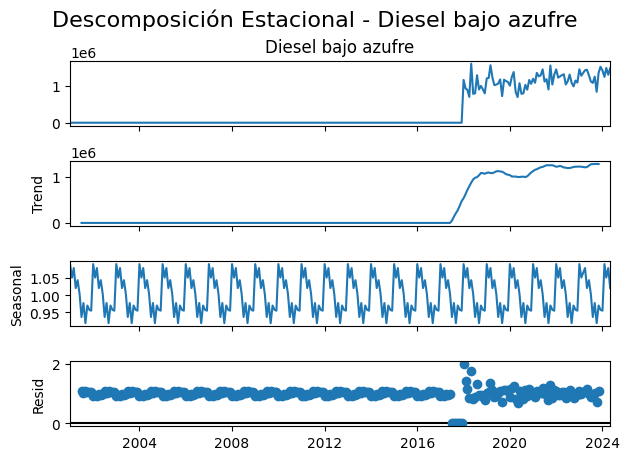

<Figure size 1200x800 with 0 Axes>

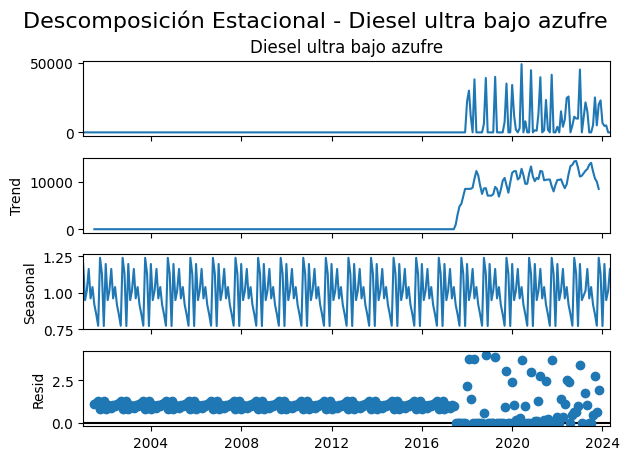

<Figure size 1200x800 with 0 Axes>

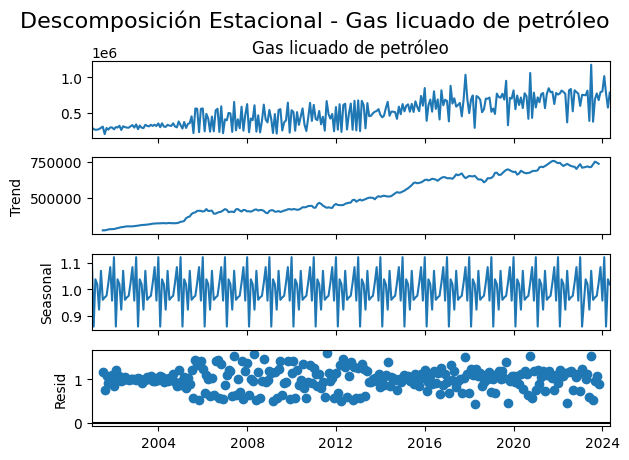

<Figure size 1200x800 with 0 Axes>

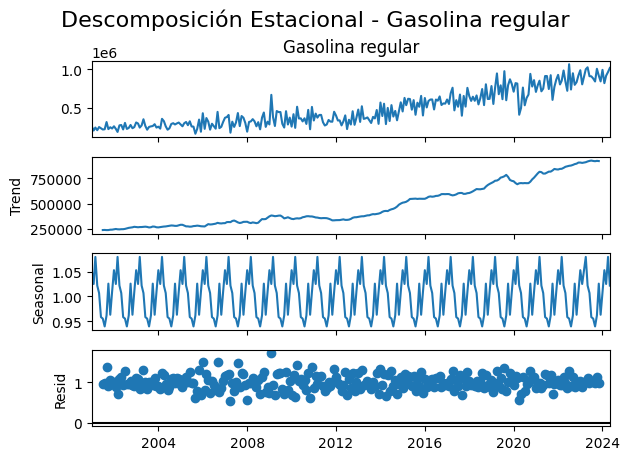

<Figure size 1200x800 with 0 Axes>

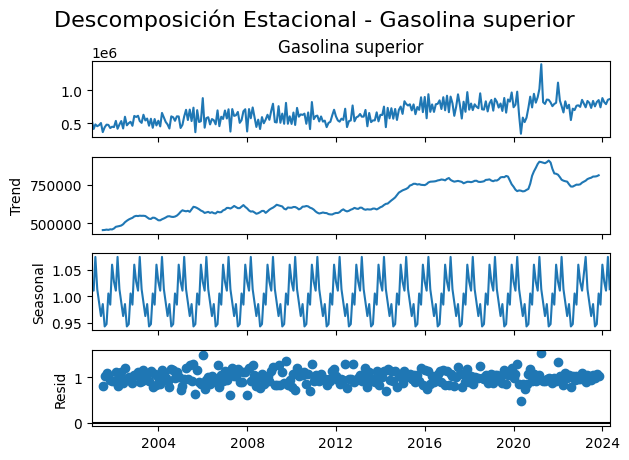

<Figure size 1200x800 with 0 Axes>

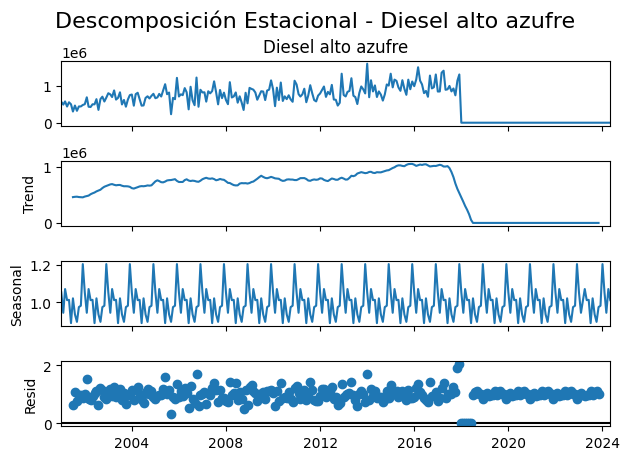

In [7]:
for column in columns_interes:
    plt.figure(figsize=(12, 8))
    
    # Agregar una constante a la serie para evitar valores cero o negativos
    data_transformed = data[column] + abs(data[column].min()) + 1
    
    # Realizar la descomposición estacional con el modelo multiplicativo
    descomposicion = seasonal_decompose(data_transformed, model='multiplicative', period=12)
    
    # Graficar la descomposición
    descomposicion.plot()
    
    # Ajustar el espaciado
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])    
    
    # Título del gráfico
    plt.suptitle(f'Descomposición Estacional - {column}', fontsize=16)
    
    # Mostrar el gráfico
    plt.show()


In [8]:
# Iterar sobre cada columna de interés y aplicar el test de Dickey-Fuller
for column in columns_interes:
    print(f'Resultados del Test de Dickey-Fuller para {column}')
    
    # Extraer la serie temporal de la columna
    serie = data[column].dropna()  # Asegurarse de que no haya valores nulos
    
    # Aplicar el test de Dickey-Fuller
    dfTest = adfuller(serie, autolag='AIC')
    
    # Almacenar los resultados en una Serie de pandas
    salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
    
    # Agregar los valores críticos
    for key, value in dfTest[4].items():
        salidaDf[f'Critical Value ({key})'] = value
    
    # Mostrar los resultados
    print(salidaDf)
    print('\n')

Resultados del Test de Dickey-Fuller para Diesel bajo azufre
Estadístico de prueba         -0.371694
p-value                        0.914719
# de retardos usados          16.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


Resultados del Test de Dickey-Fuller para Diesel ultra bajo azufre
Estadístico de prueba         -1.305242
p-value                        0.626771
# de retardos usados          11.000000
# de observaciones usadas    268.000000
Critical Value (1%)           -3.454988
Critical Value (5%)           -2.872386
Critical Value (10%)          -2.572549
dtype: float64


Resultados del Test de Dickey-Fuller para Gas licuado de petróleo
Estadístico de prueba         -0.448115
p-value                        0.901750
# de retardos usados          10.000000
# de observaciones usadas    269.000000
Critical Value (1%)           -3.454896
Critical Val

In [9]:
# Iterar sobre cada columna de interés, diferenciar y aplicar el test de Dickey-Fuller
for column in columns_interes:
    print(f'Resultados del Test de Dickey-Fuller para la serie diferenciada de {column}')
    
    # Extraer la serie temporal de la columna
    serie = data[column].dropna()  # Eliminar valores nulos
    
    # Diferenciar la serie temporal
    serie_diff = serie.diff()
    serie_diff.fillna(0, inplace=True)  # Reemplazar valores nulos resultantes de la diferenciación
    
    # Aplicar el test de Dickey-Fuller a la serie diferenciada
    dfTest = adfuller(serie_diff, autolag='AIC')
    
    # Almacenar los resultados en una Serie de pandas
    salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
    
    # Agregar los valores críticos
    for key, value in dfTest[4].items():
        salidaDf[f'Critical Value ({key})'] = value
    
    # Mostrar los resultados
    print(salidaDf)
    print('\n')

Resultados del Test de Dickey-Fuller para la serie diferenciada de Diesel bajo azufre
Estadístico de prueba         -3.786142
p-value                        0.003052
# de retardos usados          16.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


Resultados del Test de Dickey-Fuller para la serie diferenciada de Diesel ultra bajo azufre
Estadístico de prueba       -7.807409e+00
p-value                      7.219689e-12
# de retardos usados         1.000000e+01
# de observaciones usadas    2.690000e+02
Critical Value (1%)         -3.454896e+00
Critical Value (5%)         -2.872345e+00
Critical Value (10%)        -2.572528e+00
dtype: float64


Resultados del Test de Dickey-Fuller para la serie diferenciada de Gas licuado de petróleo
Estadístico de prueba       -9.628628e+00
p-value                      1.634819e-16
# de retardos usados         9.000000e+

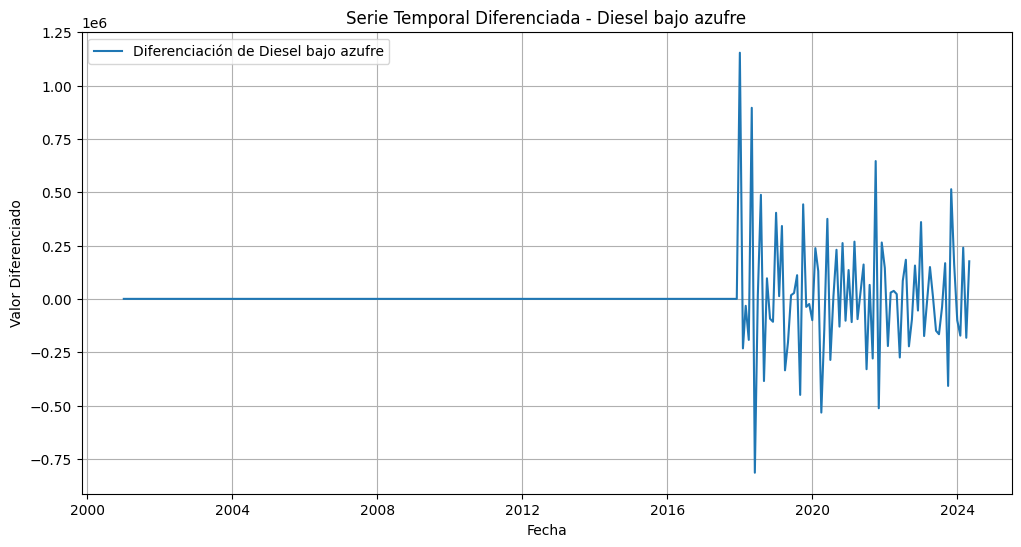

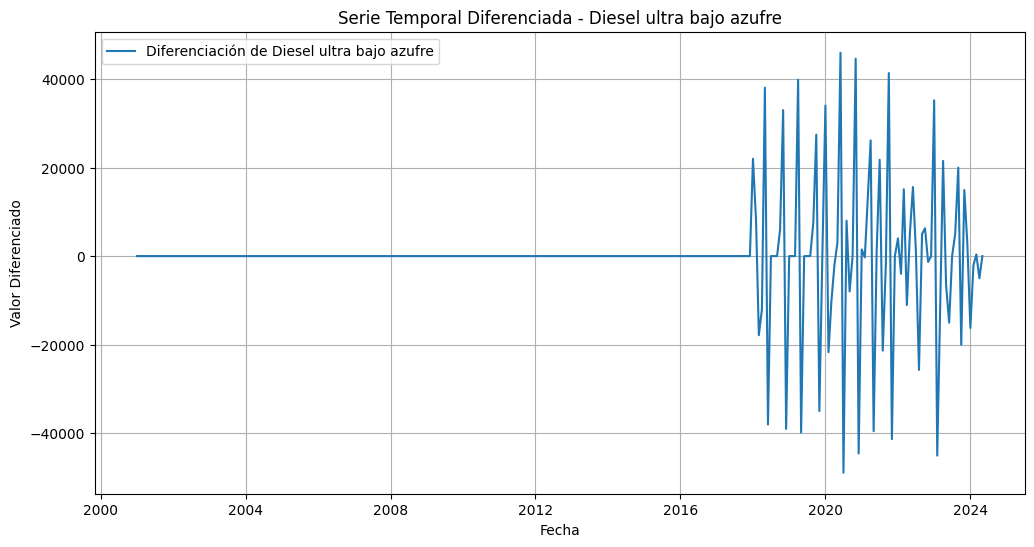

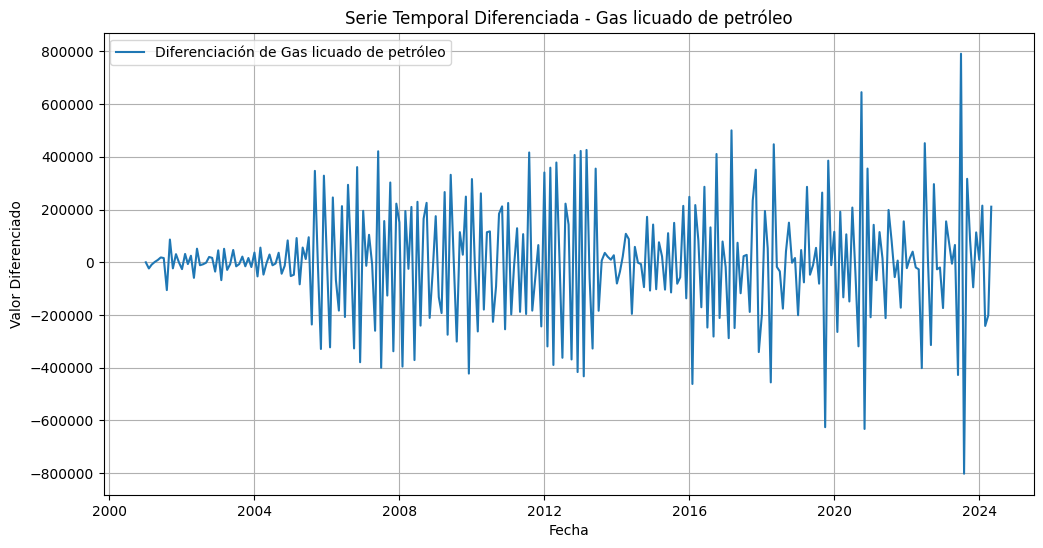

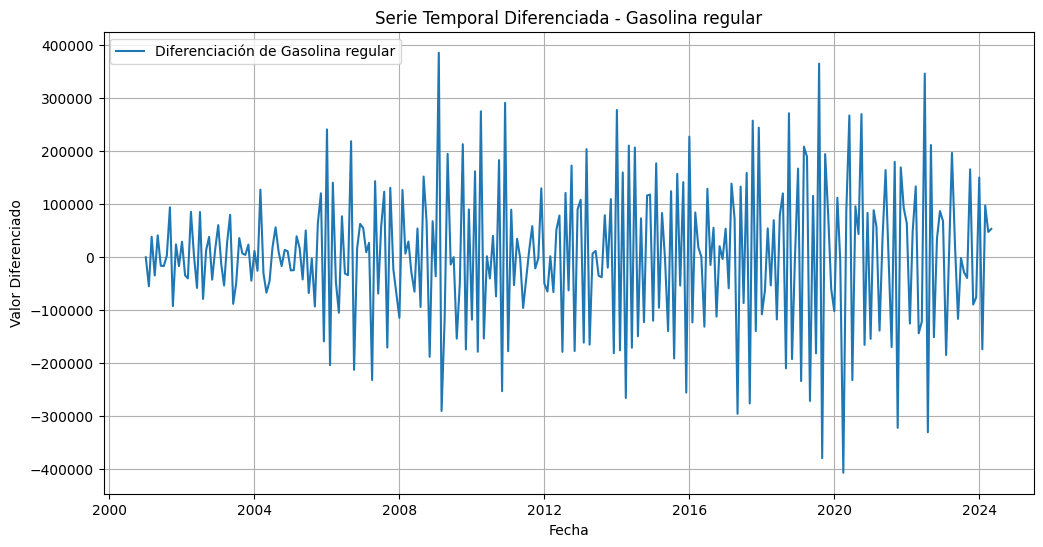

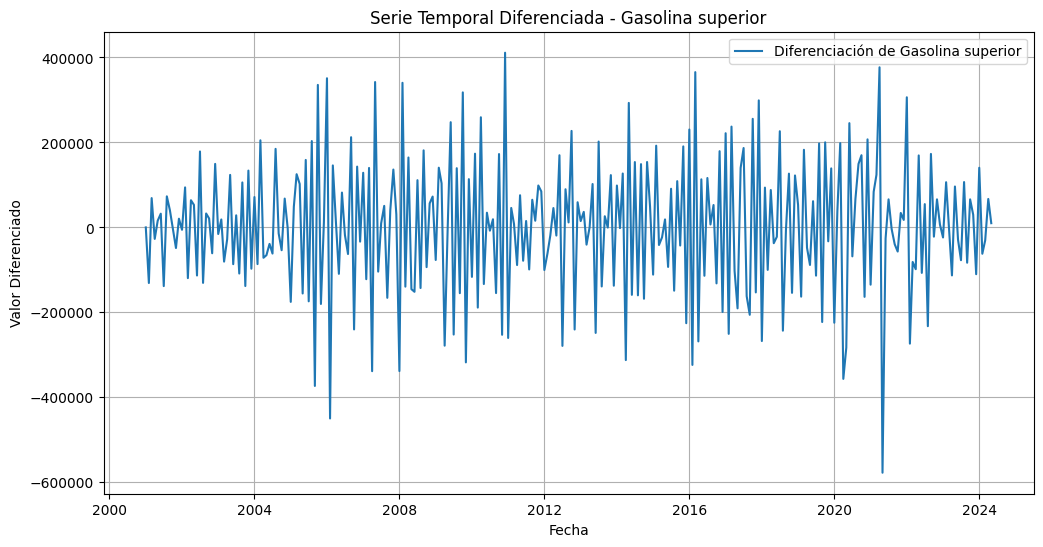

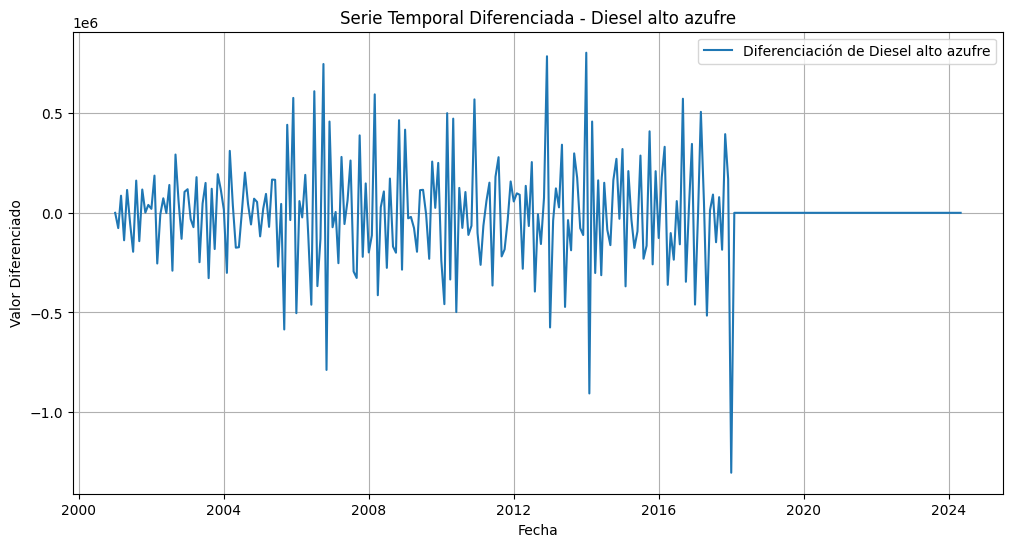

In [10]:
# Iterar sobre cada columna de interés, diferenciar y graficar
for column in columns_interes:
    plt.figure(figsize=(12, 6))
    
    # Diferenciar la serie temporal
    serie_diff = data[column].diff()
    serie_diff.fillna(0, inplace=True)  # Reemplazar valores nulos resultantes de la diferenciación
    
    # Graficar la serie temporal diferenciada
    plt.plot(serie_diff, label=f'Diferenciación de {column}')
    
    # Configurar título y etiquetas
    plt.title(f'Serie Temporal Diferenciada - {column}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Diferenciado')
    plt.legend()
    plt.grid(True)
    
    # Mostrar el gráfico
    plt.show()

In [11]:
# Inicializar el StandardScaler
scaler = StandardScaler()

# Crear un DataFrame vacío para almacenar las series normalizadas
normalized_data = pd.DataFrame(index=data.index)

# Iterar sobre cada columna de interés, diferenciar, normalizar y almacenar
for column in columns_interes:
    # Diferenciar la serie temporal
    serie_diff = data[column].diff()
    serie_diff.fillna(0, inplace=True)
    
    # Normalizar la serie diferenciada
    serie_scaled = scaler.fit_transform(serie_diff.values.reshape(-1, 1))
    
    # Convertir a un DataFrame y agregarlo al DataFrame de datos normalizados
    normalized_data[column] = serie_scaled.flatten()

# Mostrar las primeras filas de las series normalizadas
print(normalized_data.head())

# O si prefieres visualizar un subconjunto específico:
print(normalized_data.iloc[1:7])

            Diesel bajo azufre  Diesel ultra bajo azufre  \
Fecha                                                      
2001-01-01             -0.0329             -4.607748e-18   
2001-02-01             -0.0329             -4.607748e-18   
2001-03-01             -0.0329             -4.607748e-18   
2001-04-01             -0.0329             -4.607748e-18   
2001-05-01             -0.0329             -4.607748e-18   

            Gas licuado de petróleo  Gasolina regular  Gasolina superior  \
Fecha                                                                      
2001-01-01                -0.007997         -0.020174          -0.007255   
2001-02-01                -0.114583         -0.425447          -0.830303   
2001-03-01                -0.048446          0.266097           0.426638   
2001-04-01                -0.002471         -0.275137          -0.177241   
2001-05-01                 0.030647          0.286717           0.092480   

            Diesel alto azufre  
Fecha        

In [12]:
val_pruebas = {}

# Calcular val_prueba para cada serie en columns_interes
for column in columns_interes:
    val_prueba = round(0.2 * len(normalized_data[column]))
    val_pruebas[column] = val_prueba
    print(f'{column}: {val_prueba}')

Diesel bajo azufre: 56
Diesel ultra bajo azufre: 56
Gas licuado de petróleo: 56
Gasolina regular: 56
Gasolina superior: 56
Diesel alto azufre: 56


In [13]:
# Crear diccionarios para almacenar los conjuntos de datos segmentados
train_dict = {}
validation_dict = {}
test_dict = {}

# Definir el tamaño de los conjuntos de entrenamiento, validación y prueba
for column in columns_interes:
    # Calcular el tamaño de cada conjunto
    entrenamiento = round(0.6 * len(normalized_data[column]))
    val_prueba = round(0.2 * len(normalized_data[column]))

    # Crear los conjuntos de entrenamiento, validación y prueba
    test = normalized_data[column].iloc[-val_prueba:]
    validation = normalized_data[column].iloc[entrenamiento:entrenamiento + val_prueba]
    train = normalized_data[column].iloc[:entrenamiento]

    # Ajustar el formato de los datos para el modelo
    train = np.insert(train.values, 0, 0, axis=0)  # Agregar valor 0 al principio del entrenamiento
    train = np.reshape(train, (train.shape[0], 1))  # Cambiar la forma

    # Almacenar en los diccionarios
    train_dict[column] = train
    validation_dict[column] = validation
    test_dict[column] = test

    # Imprimir la longitud de cada conjunto para cada columna
    print(f'Columna: {column}')
    print(f'Longitud del conjunto de prueba: {len(test)}')
    print(f'Longitud del conjunto de validación: {len(validation)}')
    print(f'Longitud del conjunto de entrenamiento: {len(train)}\n')

# Ejemplo de acceso a los datos segmentados para una columna específica
# Ejemplo para "Gasolina superior"
example_column = 'Gasolina superior'
print('Datos de entrenamiento (ejemplo):', train_dict[example_column])
print('Datos de validación (ejemplo):', validation_dict[example_column])
print('Datos de prueba (ejemplo):', test_dict[example_column])

Columna: Diesel bajo azufre
Longitud del conjunto de prueba: 56
Longitud del conjunto de validación: 56
Longitud del conjunto de entrenamiento: 169

Columna: Diesel ultra bajo azufre
Longitud del conjunto de prueba: 56
Longitud del conjunto de validación: 56
Longitud del conjunto de entrenamiento: 169

Columna: Gas licuado de petróleo
Longitud del conjunto de prueba: 56
Longitud del conjunto de validación: 56
Longitud del conjunto de entrenamiento: 169

Columna: Gasolina regular
Longitud del conjunto de prueba: 56
Longitud del conjunto de validación: 56
Longitud del conjunto de entrenamiento: 169

Columna: Gasolina superior
Longitud del conjunto de prueba: 56
Longitud del conjunto de validación: 56
Longitud del conjunto de entrenamiento: 169

Columna: Diesel alto azufre
Longitud del conjunto de prueba: 56
Longitud del conjunto de validación: 56
Longitud del conjunto de entrenamiento: 169

Datos de entrenamiento (ejemplo): [[ 0.        ]
 [-0.00725485]
 [-0.8303025 ]
 [ 0.42663778]
 [-0

# Creacion modelo

In [14]:
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos)]
        valor_sig = serie[i + retrasos]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)


In [15]:
# Crear diccionarios para almacenar los datos de entrenamiento, validación y prueba
x_train_dict = {}
y_train_dict = {}
x_val_dict = {}
y_val_dict = {}
x_test_dict = {}
y_test_dict = {}

# Definir el número de retrasos
retrasos = 10

# Aplicar la función supervisada a cada columna y almacenar los resultados
for column in columns_interes:
    # Asegúrate de que los datos sean arrays de numpy
    train_array = train_dict[column]
    validation_array = validation_dict[column]
    test_array = test_dict[column]
    
    # Aplicar la función supervisada a los conjuntos de entrenamiento, validación y prueba
    x_train, y_train = supervisada(train_array, retrasos=retrasos)
    x_val, y_val = supervisada(validation_array, retrasos=retrasos)
    x_test, y_test = supervisada(test_array, retrasos=retrasos)
    
    # Almacenar los resultados en los diccionarios
    x_train_dict[column] = x_train
    y_train_dict[column] = y_train
    x_val_dict[column] = x_val
    y_val_dict[column] = y_val
    x_test_dict[column] = x_test
    y_test_dict[column] = y_test

    # Imprimir la forma de los datos para cada columna para verificar
    print(f'Columna: {column}')
    print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
    print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')
    print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}\n')

# Ejemplo de acceso a los datos supervisados para una columna específica
example_column = 'Gasolina superior'
print('Datos de entrenamiento (ejemplo) - X:', x_train_dict[example_column])
print('Datos de entrenamiento (ejemplo) - Y:', y_train_dict[example_column])
print('Datos de validación (ejemplo) - X:', x_val_dict[example_column])
print('Datos de validación (ejemplo) - Y:', y_val_dict[example_column])
print('Datos de prueba (ejemplo) - X:', x_test_dict[example_column])
print('Datos de prueba (ejemplo) - Y:', y_test_dict[example_column])


Columna: Diesel bajo azufre
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)

Columna: Diesel ultra bajo azufre
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)

Columna: Gas licuado de petróleo
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)

Columna: Gasolina regular
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)

Columna: Gasolina superior
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)

Columna: Diesel alto azufre
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_tes

/tmp/ipykernel_74727/4138540431.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valor_sig = serie[i + retrasos]


In [16]:

# Columnas de interés
columns_interes = [
    'Diesel bajo azufre',
    'Diesel ultra bajo azufre',
    'Gas licuado de petróleo',
    'Gasolina regular',
    'Gasolina superior',
    'Diesel alto azufre'
]

# Número de pasos de tiempo (retrasos)
retrasos = 10

# Diccionarios para almacenar los resultados reestructurados
x_train_reshaped_dict = {}
x_val_reshaped_dict = {}
x_test_reshaped_dict = {}

# Aplicar la función supervisada a cada columna y almacenar los resultados
for column in columns_interes:
    # Convertir los datos a numpy arrays
    x_train_array = x_train_dict[column].reshape(-1)  # Aplanar en caso de ser necesario
    x_val_array = x_val_dict[column].reshape(-1)
    x_test_array = x_test_dict[column].reshape(-1)

    # Aplicar la función supervisada
    x_train, y_train = supervisada(x_train_array, retrasos=retrasos)
    x_val, y_val = supervisada(x_val_array, retrasos=retrasos)
    x_test, y_test = supervisada(x_test_array, retrasos=retrasos)

    # Reestructurar los datos
    x_train_reshaped = np.reshape(x_train, (x_train.shape[0], retrasos, 1))
    x_val_reshaped = np.reshape(x_val, (x_val.shape[0], retrasos, 1))
    x_test_reshaped = np.reshape(x_test, (x_test.shape[0], retrasos, 1))

    # Almacenar los datos reestructurados en los diccionarios
    x_train_reshaped_dict[column] = x_train_reshaped
    x_val_reshaped_dict[column] = x_val_reshaped
    x_test_reshaped_dict[column] = x_test_reshaped

    # Imprimir la longitud del conjunto de validación para verificar
    print(f'Columna: {column}')
    print(f'x_train_reshaped_dict[column]: {x_train_reshaped.shape}')
    print(f'x_val_reshaped_dict[column]: {x_val_reshaped.shape}')
    print(f'x_test_reshaped_dict[column]: {x_test_reshaped.shape}\n')


Columna: Diesel bajo azufre
x_train_reshaped_dict[column]: (1580, 10, 1)
x_val_reshaped_dict[column]: (450, 10, 1)
x_test_reshaped_dict[column]: (450, 10, 1)

Columna: Diesel ultra bajo azufre
x_train_reshaped_dict[column]: (1580, 10, 1)
x_val_reshaped_dict[column]: (450, 10, 1)
x_test_reshaped_dict[column]: (450, 10, 1)

Columna: Gas licuado de petróleo
x_train_reshaped_dict[column]: (1580, 10, 1)
x_val_reshaped_dict[column]: (450, 10, 1)
x_test_reshaped_dict[column]: (450, 10, 1)

Columna: Gasolina regular
x_train_reshaped_dict[column]: (1580, 10, 1)
x_val_reshaped_dict[column]: (450, 10, 1)
x_test_reshaped_dict[column]: (450, 10, 1)

Columna: Gasolina superior
x_train_reshaped_dict[column]: (1580, 10, 1)
x_val_reshaped_dict[column]: (450, 10, 1)
x_test_reshaped_dict[column]: (450, 10, 1)

Columna: Diesel alto azufre
x_train_reshaped_dict[column]: (1580, 10, 1)
x_val_reshaped_dict[column]: (450, 10, 1)
x_test_reshaped_dict[column]: (450, 10, 1)



In [17]:
from tensorflow import keras

# Definir parámetros
lote = 1
unidades = 50  # Ajusta este valor según la complejidad deseada
paso = 10  # Número de pasos de tiempo en la secuencia
caracteristicas = 1  # Número de características (en este caso, es univariada)

# Definir la arquitectura del modelo
inputs = keras.layers.Input(shape=(paso, caracteristicas))
lstm_out = keras.layers.LSTM(unidades)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

# Crear el modelo
modelo1 = keras.Model(inputs=inputs, outputs=outputs)

# Mostrar el resumen del modelo
modelo1.summary()


2024-08-10 22:29:15.167993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 22:29:15.168520: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Definir el EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilar el modelo
modelo1.compile(loss='mean_squared_error',
                optimizer=Adam(learning_rate=0.01),  # Ajusta la tasa de aprendizaje según sea necesario
                metrics=[RootMeanSquaredError()])

# Mostrar el resumen del modelo
modelo1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Definir EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilar el modelo
modelo1.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.1),  # Ajusta la tasa de aprendizaje si es necesario
    metrics=[RootMeanSquaredError()]
)

# Número de épocas y tamaño del lote
epocas = 150
lote = 1

# Entrenamiento del modelo
history = modelo1.fit(
    x=x_train,  # Datos de entrada para entrenamiento
    y=y_train,  # Etiquetas para entrenamiento
    batch_size=lote,  # Tamaño del lote
    epochs=epocas,  # Número de épocas
    shuffle=False,  # Mantener el orden temporal
    validation_data=(x_val, y_val),  # Datos de validación
    callbacks=[early_stop],  # Aplicar EarlyStopping
    verbose=1  # Mostrar el progreso del entrenamiento
)


Epoch 1/150
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6771 - root_mean_squared_error: 0.8073 - val_loss: 2.6905 - val_root_mean_squared_error: 1.6403
Epoch 2/150
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6254 - root_mean_squared_error: 0.7742 - val_loss: 2.2266 - val_root_mean_squared_error: 1.4922
Epoch 3/150
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5996 - root_mean_squared_error: 0.7576 - val_loss: 2.4109 - val_root_mean_squared_error: 1.5527
Epoch 4/150
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6100 - root_mean_squared_error: 0.7612 - val_loss: 2.4844 - val_root_mean_squared_error: 1.5762
Epoch 5/150
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5774 - root_mean_squared_error: 0.7406 - val_loss: 3.8707 - val_root_mean_squared_error: 1.9674
Epoch 6/150
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6603 - root_mean_squared_error: 0.7997 - val_loss: 2.7704 - val_root_mean_squared_error: 1.6645
Epoch 7/150
1580/1580 ━━━━━━━━━━━━

In [20]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')


x_train shape: (1580, 10)
y_train shape: (1580,)
x_val shape: (450, 10)
y_val shape: (450,)


In [21]:
x_train_array = train_dict[column]
print(f'Longitud original de x_train_array: {len(x_train_array)}')

x_train, y_train = supervisada(x_train_array, retrasos=retrasos)
print(f'Longitud de x_train después de supervisada: {x_train.shape[0]}')
print(f'Longitud de y_train después de supervisada: {y_train.shape[0]}')


Longitud original de x_train_array: 169
Longitud de x_train después de supervisada: 159
Longitud de y_train después de supervisada: 159


In [22]:
for column in columns_interes:
    # Obtener datos para la columna actual
    train_array = train_dict[column]
    validation_array = validation_dict[column]
    test_array = test_dict[column]

    # Aplicar la función supervisada a los conjuntos de entrenamiento, validación y prueba
    x_train, y_train = supervisada(train_array, retrasos=retrasos)
    x_val, y_val = supervisada(validation_array, retrasos=retrasos)
    x_test, y_test = supervisada(test_array, retrasos=retrasos)

    # Verificar la longitud de los datos
    print(f'Columna: {column}')
    print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
    print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')
    print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

    # Reestructurar los datos
    x_train_reshaped = np.reshape(x_train, (x_train.shape[0], retrasos, 1))
    x_val_reshaped = np.reshape(x_val, (x_val.shape[0], retrasos, 1))
    x_test_reshaped = np.reshape(x_test, (x_test.shape[0], retrasos, 1))

    # Almacenar los datos reestructurados en los diccionarios
    x_train_reshaped_dict[column] = x_train_reshaped
    y_train_dict[column] = y_train  # Asegúrate de que 'y_train' es la etiqueta
    x_val_reshaped_dict[column] = x_val_reshaped
    y_val_dict[column] = y_val
    x_test_reshaped_dict[column] = x_test_reshaped
    y_test_dict[column] = y_test


Columna: Diesel bajo azufre
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)
Columna: Diesel ultra bajo azufre
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)
Columna: Gas licuado de petróleo
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)
Columna: Gasolina regular
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)
Columna: Gasolina superior
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test shape: (46,)
Columna: Diesel alto azufre
x_train shape: (159, 10, 1), y_train shape: (159, 1)
x_val shape: (46, 10), y_val shape: (46,)
x_test shape: (46, 10), y_test sha

/tmp/ipykernel_74727/4138540431.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valor_sig = serie[i + retrasos]


Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6455e-04 - root_mean_squared_error: 0.0142 - val_loss: 3.1690 - val_root_mean_squared_error: 1.7802
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6485e-10 - root_mean_squared_error: 1.0941e-05 - val_loss: 3.1690 - val_root_mean_squared_error: 1.7802
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3817e-10 - root_mean_squared_error: 1.3670e-05 - val_loss: 3.1690 - val_root_mean_squared_error: 1.7802
Epoch 4/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8240e-10 - root_mean_squared_error: 1.5022e-05 - val_loss: 3.1690 - val_root_mean_squared_error: 1.7802
Columna: Diesel bajo azufre
x_train_reshaped.shape: (159, 10, 1)
y_train.shape: (159, 1)
x_val_reshaped.shape: (46, 10, 1)
y_val.shape: (46,)


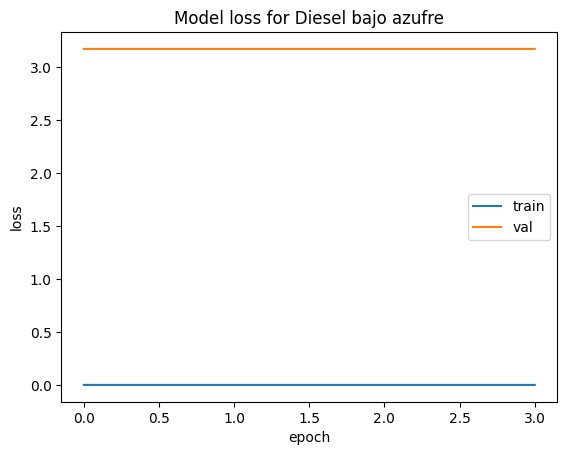

Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4871e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.6631 - val_root_mean_squared_error: 1.2896
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6474e-12 - root_mean_squared_error: 1.7363e-06 - val_loss: 1.6631 - val_root_mean_squared_error: 1.2896
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6228e-20 - root_mean_squared_error: 2.8074e-10 - val_loss: 1.6631 - val_root_mean_squared_error: 1.2896
Epoch 4/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1231e-35 - root_mean_squared_error: 4.6077e-18 - val_loss: 1.6631 - val_root_mean_squared_error: 1.2896
Columna: Diesel ultra bajo azufre
x_train_reshaped.shape: (159, 10, 1)
y_train.shape: (159, 1)
x_val_reshaped.shape: (46, 10, 1)
y_val.shape: (46,)


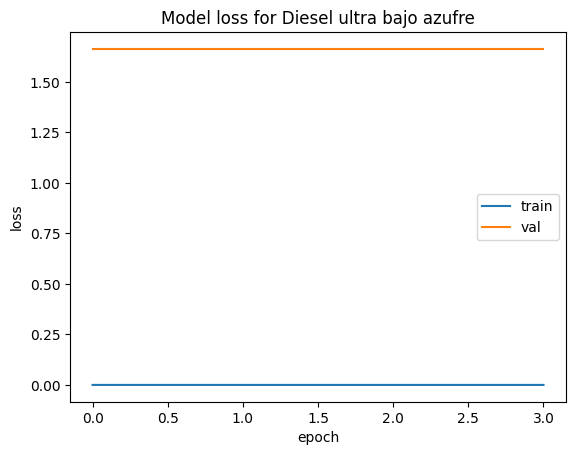

Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2226 - root_mean_squared_error: 0.4284 - val_loss: 0.5076 - val_root_mean_squared_error: 0.7125
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1768 - root_mean_squared_error: 0.3723 - val_loss: 0.5862 - val_root_mean_squared_error: 0.7657
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1727 - root_mean_squared_error: 0.3709 - val_loss: 0.7200 - val_root_mean_squared_error: 0.8485
Epoch 4/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1746 - root_mean_squared_error: 0.3721 - val_loss: 0.8050 - val_root_mean_squared_error: 0.8972
Columna: Gas licuado de petróleo
x_train_reshaped.shape: (159, 10, 1)
y_train.shape: (159, 1)
x_val_reshaped.shape: (46, 10, 1)
y_val.shape: (46,)


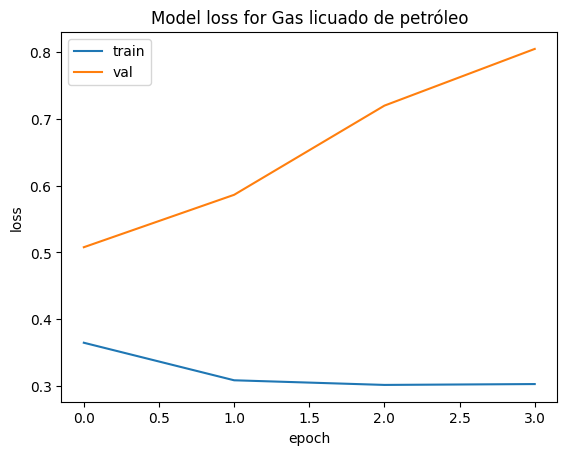

Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3020 - root_mean_squared_error: 0.5357 - val_loss: 0.6513 - val_root_mean_squared_error: 0.8070
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - root_mean_squared_error: 0.4989 - val_loss: 0.6093 - val_root_mean_squared_error: 0.7806
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2549 - root_mean_squared_error: 0.4917 - val_loss: 0.5954 - val_root_mean_squared_error: 0.7716
Columna: Gasolina regular
x_train_reshaped.shape: (159, 10, 1)
y_train.shape: (159, 1)
x_val_reshaped.shape: (46, 10, 1)
y_val.shape: (46,)


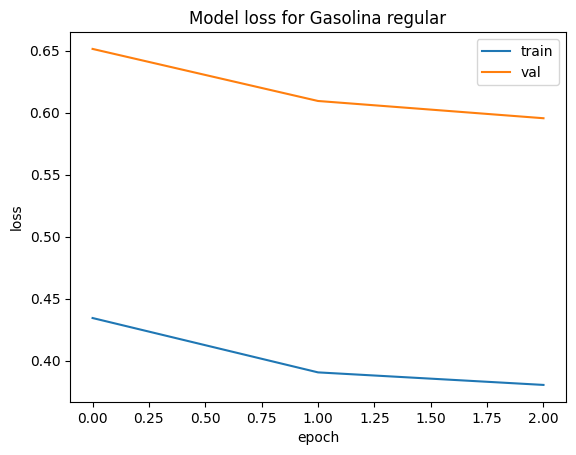

Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4466 - root_mean_squared_error: 0.6550 - val_loss: 0.5396 - val_root_mean_squared_error: 0.7346
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3796 - root_mean_squared_error: 0.6030 - val_loss: 0.4772 - val_root_mean_squared_error: 0.6908
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3856 - root_mean_squared_error: 0.6090 - val_loss: 0.4608 - val_root_mean_squared_error: 0.6789
Epoch 4/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3694 - root_mean_squared_error: 0.5949 - val_loss: 0.4660 - val_root_mean_squared_error: 0.6827
Epoch 5/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3705 - root_mean_squared_error: 0.5993 - val_loss: 0.4623 - val_root_mean_squared_error: 0.6800
Epoch 6/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3657 - root_mean_squared_error: 0.5956 - val_loss: 0.4737 - val_root_mean_squared_error: 0.6882
Columna: Gasolina superior
x_train_reshaped.sh

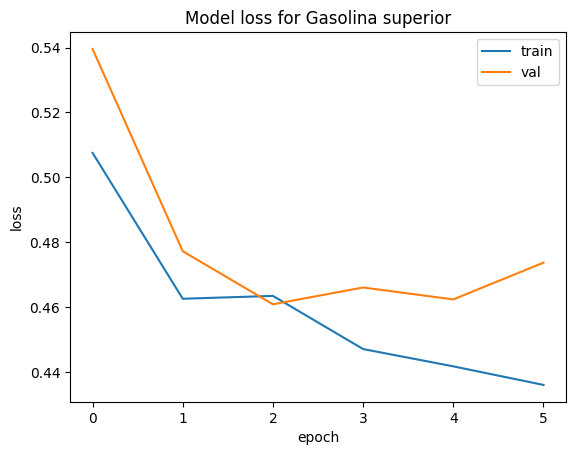

Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6347 - root_mean_squared_error: 0.7815 - val_loss: 1.1555 - val_root_mean_squared_error: 1.0750
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5570 - root_mean_squared_error: 0.7243 - val_loss: 1.1169 - val_root_mean_squared_error: 1.0568
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6449 - root_mean_squared_error: 0.7838 - val_loss: 1.8900 - val_root_mean_squared_error: 1.3748
Columna: Diesel alto azufre
x_train_reshaped.shape: (159, 10, 1)
y_train.shape: (159, 1)
x_val_reshaped.shape: (46, 10, 1)
y_val.shape: (46,)


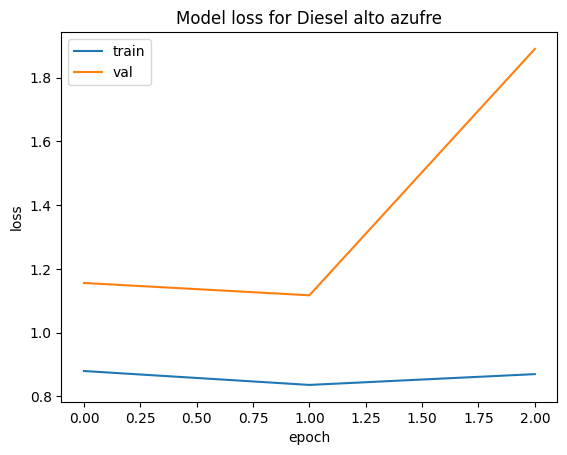

In [23]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Parámetros del modelo
lote = 1
unidades = 50  # Número de unidades LSTM
paso = 10  # Número de pasos de tiempo
caracteristicas = 1  # Número de características

# Crear diccionario para almacenar los historiales
history_dict = {}

# Definir el EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Definir el entrenamiento para cada columna
for column in columns_interes:
    # Obtener datos para la columna actual
    x_train_reshaped = x_train_reshaped_dict[column]
    y_train = y_train_dict[column]
    x_val_reshaped = x_val_reshaped_dict[column]
    y_val = y_val_dict[column]

    # Definir la arquitectura del modelo
    inputs = keras.layers.Input(shape=(paso, caracteristicas))
    lstm_out = keras.layers.LSTM(unidades)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    # Crear el modelo
    modelo1 = keras.Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    modelo1.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.01),  # Ajusta la tasa de aprendizaje si es necesario
        metrics=[RootMeanSquaredError()]
    )

    # Entrenar el modelo
    history = modelo1.fit(
        x=x_train_reshaped,  # Datos de entrada para entrenamiento
        y=y_train,  # Etiquetas para entrenamiento
        batch_size=lote,  # Tamaño del lote
        epochs=150,  # Número de épocas
        shuffle=False,  # Mantener el orden temporal
        validation_data=(x_val_reshaped, y_val),  # Datos de validación
        callbacks=[early_stop],  # Aplicar EarlyStopping
        verbose=1  # Mostrar el progreso del entrenamiento
    )

    # Almacenar el historial de entrenamiento
    history_dict[column] = history

    # Imprimir la longitud del conjunto de validación para verificar
    print(f'Columna: {column}')
    print(f'x_train_reshaped.shape: {x_train_reshaped.shape}')
    print(f'y_train.shape: {y_train.shape}')
    print(f'x_val_reshaped.shape: {x_val_reshaped.shape}')
    print(f'y_val.shape: {y_val.shape}')

    # Graficar el historial de pérdida
    import matplotlib.pyplot as plt

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss for {column}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
    plt.show()


In [24]:
print("Tipos de datos y formas:")
print(f"x_train_reshaped_dict[{column}].dtype: {x_train_reshaped_dict[column].dtype}, shape: {x_train_reshaped_dict[column].shape}")
print(f"y_train_dict[{column}].dtype: {y_train_dict[column].dtype}, shape: {y_train_dict[column].shape}")


Tipos de datos y formas:
x_train_reshaped_dict[Diesel alto azufre].dtype: float64, shape: (159, 10, 1)
y_train_dict[Diesel alto azufre].dtype: float64, shape: (159, 1)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

modelo1 = Sequential([
    LSTM(50, activation='relu', input_shape=(10, 1)),
    Dense(1)  # La salida debe coincidir con la forma de y_train_dict[column]
])

modelo1.compile(optimizer='adam', loss='mean_squared_error')


/home/arg/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Verificar la forma y el tipo de datos antes de evaluar
print(f"x_train_reshaped_dict[{column}].shape: {x_train_reshaped_dict[column].shape}")
print(f"y_train_dict[{column}].shape: {y_train_dict[column].shape}")

# Evaluar el modelo
try:
    print("Pérdida en Entrenamiento")
    loss_train = modelo1.evaluate(x=x_train_reshaped_dict[column], y=y_train_dict[column], verbose=0)
    print("Pérdida en Validación")
    loss_val = modelo1.evaluate(x=x_val_reshaped_dict[column], y=y_val_dict[column], verbose=0)
    print("Pérdida en Prueba")
    loss_test = modelo1.evaluate(x=x_test_reshaped_dict[column], y=y_test_dict[column], verbose=0)
    
    print(f"Pérdida en Entrenamiento: {loss_train}")
    print(f"Pérdida en Validación: {loss_val}")
    print(f"Pérdida en Prueba: {loss_test}")
except Exception as e:
    print(f"Error al evaluar el modelo: {e}")


x_train_reshaped_dict[Diesel alto azufre].shape: (159, 10, 1)
y_train_dict[Diesel alto azufre].shape: (159, 1)
Pérdida en Entrenamiento
Pérdida en Validación
Error al evaluar el modelo: Cannot take the length of shape with unknown rank.


In [27]:
x_train_small = x_train_reshaped_dict[column][:10]
y_train_small = y_train_dict[column][:10]

modelo1.fit(x=x_train_small, y=y_train_small, epochs=1, batch_size=1, verbose=1)

# Evaluar el modelo con el pequeño conjunto de datos
loss_train_small = modelo1.evaluate(x=x_train_small, y=y_train_small, verbose=0)
print(f"Pérdida en Entrenamiento con datos pequeños: {loss_train_small}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1065  
Pérdida en Entrenamiento con datos pequeños: 0.21694180369377136


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


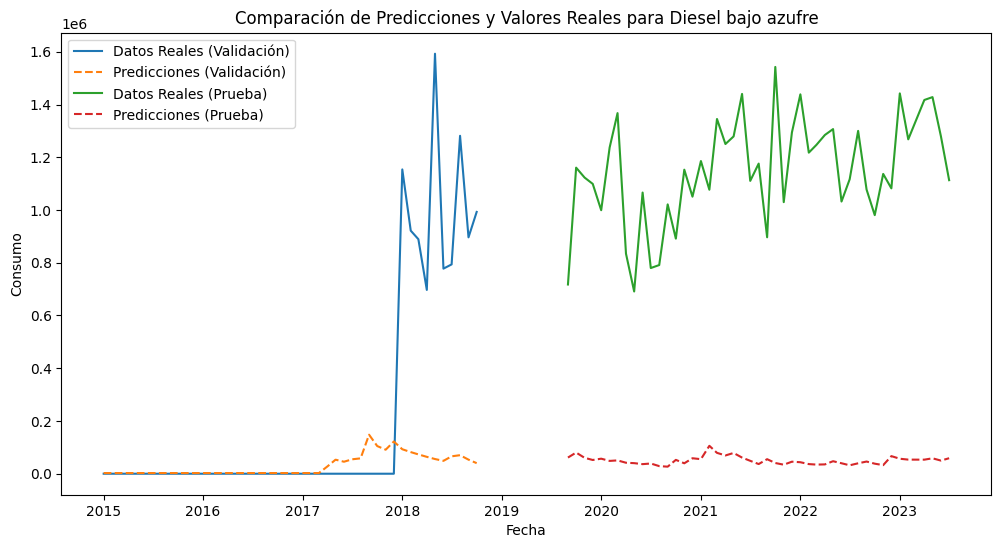

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Generar las predicciones para los conjuntos de validación y prueba
predictions_val = modelo1.predict(x_val_reshaped_dict['Diesel bajo azufre'])
predictions_test = modelo1.predict(x_test_reshaped_dict['Diesel bajo azufre'])

# Invertir el escalado
predictions_val = scaler.inverse_transform(predictions_val.reshape(-1, 1)).flatten()
predictions_test = scaler.inverse_transform(predictions_test.reshape(-1, 1)).flatten()

# Ajustar índices para las predicciones de validación
val_indices = data.index[entrenamiento:entrenamiento + len(predictions_val)]

# Ajustar índices para las predicciones de prueba
test_indices = data.index[entrenamiento + val_prueba:entrenamiento + val_prueba + len(predictions_test)]

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Datos de validación
plt.plot(val_indices, data['Diesel bajo azufre'].values[entrenamiento:entrenamiento + len(predictions_val)], label='Datos Reales (Validación)')
plt.plot(val_indices, predictions_val, label='Predicciones (Validación)', linestyle='--')

# Datos de prueba
plt.plot(test_indices, data['Diesel bajo azufre'].values[entrenamiento + val_prueba:entrenamiento + val_prueba + len(predictions_test)], label='Datos Reales (Prueba)')
plt.plot(test_indices, predictions_test, label='Predicciones (Prueba)', linestyle='--')

plt.title('Comparación de Predicciones y Valores Reales para Diesel bajo azufre')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()



In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
data = pd.read_csv('depurado.csv')

# Select the column of interest
column = 'Diesel bajo azufre'
data_column = data[[column]].dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_column)

# Create sequences for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training, validation, and test sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (189, 10, 1), y_train shape: (189, 1)
X_val shape: (40, 10, 1), y_val shape: (40, 1)
X_test shape: (41, 10, 1), y_test shape: (41, 1)


In [30]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)


Epoch 1/50


/home/arg/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.3218
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [31]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")


Train Loss: 0.0
Validation Loss: 0.32179030776023865


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


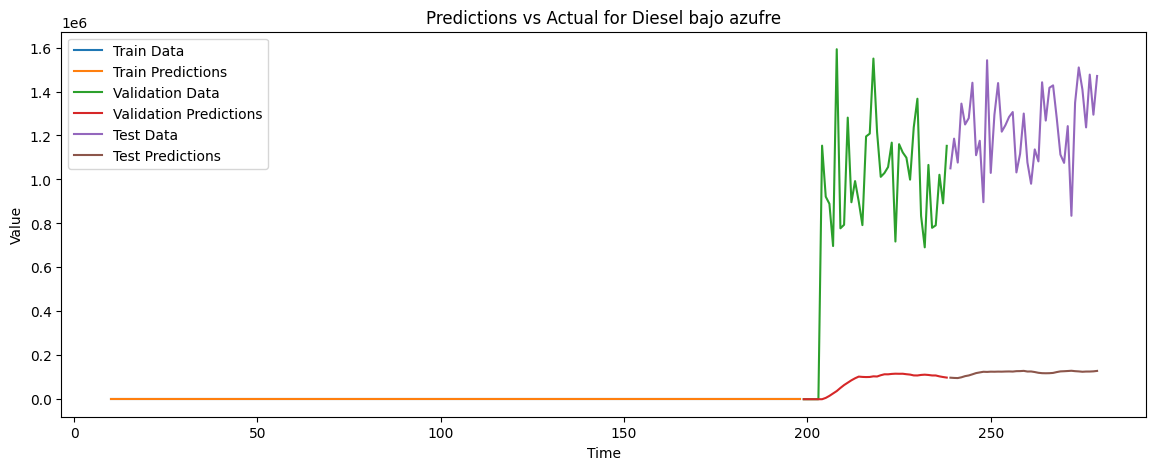

In [32]:
# Make predictions
predictions_train = model.predict(X_train)
predictions_val = model.predict(X_val)
predictions_test = model.predict(X_test)

# Inverse transform the predictions
predictions_train = scaler.inverse_transform(predictions_train)
predictions_val = scaler.inverse_transform(predictions_val)
predictions_test = scaler.inverse_transform(predictions_test)

# Plot the results
plt.figure(figsize=(14, 5))

# Plot training data
plt.plot(data[column].index[sequence_length:train_size + sequence_length], 
         data[column].values[sequence_length:train_size + sequence_length], label='Train Data')
plt.plot(data[column].index[sequence_length:train_size + sequence_length], 
         predictions_train, label='Train Predictions')

# Plot validation data
plt.plot(data[column].index[train_size + sequence_length:train_size + sequence_length + val_size], 
         data[column].values[train_size + sequence_length:train_size + sequence_length + val_size], label='Validation Data')
plt.plot(data[column].index[train_size + sequence_length:train_size + sequence_length + val_size], 
         predictions_val, label='Validation Predictions')

# Plot test data
plt.plot(data[column].index[train_size + sequence_length + val_size:], 
         data[column].values[train_size + sequence_length + val_size:], label='Test Data')
plt.plot(data[column].index[train_size + sequence_length + val_size:], 
         predictions_test, label='Test Predictions')

plt.title(f'Predictions vs Actual for {column}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
